# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Get the data

In [1]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [2]:
root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

data_folder_name = 'image-training-corpus+annotations'
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

data_zip_name = 'dl2018-image-proj.zip'
DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
    zip_f.extractall(train_path)

KeyboardInterrupt: 

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

First we want to split the data into training and validation sets. A very important thing to consider is to have the same distribution of classes in both datasets, especially in our case where the data is imbalanced. In multi-class classification we could do this by stratified sampling, but in our case the data is also multi-labeled, so the strata would not be exclusive. Luckily there is a method of stratified sampling for multi-label classification called *iterative stratification*, for which an implementation is provided in `skmultilearn`. A commonly used 80/20 split is used to split the data into training and validation, respectively. NB! The code below assumes that the training images are in the current directory in `train_original/images` and the labels in `train_original/annotations/<classname>.txt`.

In [2]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

def trainValSplit(image_folder, test_size):
    
    X = sorted([int(filename[2:-4]) for filename in os.listdir(image_folder)]) # read the image numbers as int, sorted
    class_names = ["baby", "bird", "car", "clouds", "dog", "female", "flower", "male", "night", "people", "portrait", "river", "sea", "tree"]
    # the line below reach each annotation file and makes a set containing all image numbers corresponding to that class
    class_dict = {classname:set(np.loadtxt(f"train_original/annotations/{classname}.txt", dtype=int)) for classname in class_names}
    y = []
    for img in range(1,20001):
        labels = np.zeros(len(class_names)) # make a one-hot vector for the labels
        for i, classname in enumerate(class_names): # iterate through classnames
            labelsInClass = class_dict[classname] 
            if img in labelsInClass: 
                labels[i] = 1 # if the image is in the class, set label to 1
        y.append(labels)
    y = np.array(y)
    X = np.array(X)
    # iterative_train_test_split does not accept only one number as input, so we 
    # add a column of zeros to X as placeholder and discard it later when the split is done
    X = np.c_[X, np.zeros(20000)] 
    # split the data: X are image numbers and y are labels corresponding to that image number
    X_train, y_train, X_val, y_val = iterative_train_test_split(X, y, test_size = test_size)

    X_train = X_train[:,0].astype(int) # discard the additional column
    X_val = X_val[:,0].astype(int) 
    # the values below should be very close together
    print("Training data relative class frequencies: ", np.sum(y_train, axis=0)/y_train.shape[0])
    print("Validation data relative class frequencies: ", np.sum(y_val, axis=0)/y_val.shape[0])
    
    X = {"train":X_train, "val":X_val}
    y = {"train":y_train, "val":y_val}
    
    return X, y

In [3]:
X, y = trainValSplit("train_original/images", test_size=0.2)
assert not np.array_equal(X["train"] , X["val"]) # assert that no image is in both sets

Training data relative class frequencies:  [0.0046875 0.018     0.0159375 0.05475   0.022375  0.161375  0.0380625
 0.1489375 0.029875  0.320125  0.1560625 0.006     0.008625  0.02625  ]
Validation data relative class frequencies:  [0.005   0.018   0.016   0.05475 0.0225  0.16125 0.038   0.149   0.03
 0.32025 0.156   0.006   0.00875 0.02625]


Now we proceed to make a custom PyTorch dataset for training and validation. We need to implement `__init__`, `__getitem__` and `__len__` methods. We can't load all images to memory in the `__init__` method due to memory constraints (would require ~8 GB of memory), although this would make `__getitem__` faster. So instead we load the images to memory one by one in the `__getitem__` method.

In [4]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

class ImageDataSet(Dataset):
    def __init__(self, image_numbers, labels, transformations):
        self.images = image_numbers
        self.labels = labels
        self.image_count = len(self.images)
        self.transformations = transformations
        
    def __getitem__(self, index):                
        # we don't actually know the numbers of the images in the data set after the split, so we need to use
        # an "auxiliary" array containing the image numbers to get an image at [index]
        img = plt.imread(f"train_original/images/im{self.images[index]}.jpg")
        # the dimensions of input need to be the same for all input, so we change greyscale images (128x128)
        # to RGB (128x128x3)
        if len(img.shape) < 3: # check for greyscale images
            img = np.stack((img,)*3, axis=-1) # add 3 dimensions to the last axis
        labels = self.labels[index]

        img = self.transformations(img) # apply transformations to the image only

        return (img, labels)

    def __len__(self):
        return self.image_count

Next we define the transformations used for the images. From `torchvision` documentation we find that the pretrained networks used for transfer learning expect 3-channel RGB images whose height and width should be at least 224 pixels, and they should be normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. For data augmentation we use random horizontal flips, random rotations and random resized crops . The latter crops the image randomly and resizes it to the given value. The images are resized to 224x224, as per recommendation by `torchvision`. Then we proceed to load the data sets and define the dataloaders to feed the data to the network in batches. 

In [12]:
from torch.utils.data import DataLoader

data_transforms = {
    "train": transforms.Compose([
        transforms.ToPILImage(), # torchvision image transformations require PIL images
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25), # -25 to 25 degree rotation
        transforms.ToTensor(), # scales the pixel values to the range [0,1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: ImageDataSet(X[x], y[x], data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ["train", "val"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next we define a general function to train a model.

In [13]:
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score, hamming_loss

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # copy the model weights
    best_f1 = 0.0
    
    losses = {x:[] for x in ["train", "val"]}
    f1_scores = {x:[] for x in ["train", "val"]}
    acc = {x:[] for x in ["train", "val"]}
    
    for epoch in range(1,num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1_score = 0.0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs).double()
                    preds = torch.sigmoid(outputs) > 0.5 # apply sigmoid because it is merged with the loss (=criterion)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step() # change each batch

                # statistics, weighted averages
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += accuracy_score(labels.data.cpu(), preds.data.cpu(), normalize=False)
                running_f1_score += f1_score(labels.data.cpu(), preds.data.cpu(), average="micro") * inputs.size(0)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            epoch_f1 = running_f1_score / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            f1_scores[phase].append(epoch_f1)
            acc[phase].append(epoch_acc)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

            # deep copy the model
            if phase == "val" and epoch_f1 > best_f1: # use micro-averaged F1-score as the performance metric
                best_f1 = epoch_f1
                # change the model weights to the one that performs best on validation data
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, f1_scores, acc

Load a pretrained network. `ResNet34` is used, since it strikes a good balance with classification accuracy and model size. This is important because we want to be able to fit the model _and_ the data in GPU memory. 

In [18]:
model_ft = models.resnet34(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 14) # 14 classes so 14 neurons in the output layer


model_ft = model_ft.to(device)

# use binary cross-entropy as the loss for each neuron and take the average
criterion = nn.BCEWithLogitsLoss() # has a sigmoid layer merged with the loss for improved numerical stability

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

epochs = 20
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.01, total_steps=None, epochs=epochs, steps_per_epoch=len(dataloaders["train"]), pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)

In [19]:
model_ft, losses, f1, acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                                      num_epochs=epochs)

Epoch 1/20
----------
train Loss: 0.2263 Acc: 0.4610 F1: 0.1101
val Loss: 0.1810 Acc: 0.4760 F1: 0.3831

Epoch 2/20
----------
train Loss: 0.1708 Acc: 0.4931 F1: 0.3734
val Loss: 0.1528 Acc: 0.5220 F1: 0.5060

Epoch 3/20
----------
train Loss: 0.1541 Acc: 0.5123 F1: 0.4835
val Loss: 0.1381 Acc: 0.5400 F1: 0.5465

Epoch 4/20
----------
train Loss: 0.1438 Acc: 0.5304 F1: 0.5278
val Loss: 0.1298 Acc: 0.5490 F1: 0.5730

Epoch 5/20
----------
train Loss: 0.1391 Acc: 0.5366 F1: 0.5413
val Loss: 0.1253 Acc: 0.5517 F1: 0.5686

Epoch 6/20
----------
train Loss: 0.1352 Acc: 0.5426 F1: 0.5540
val Loss: 0.1226 Acc: 0.5693 F1: 0.5703

Epoch 7/20
----------
train Loss: 0.1344 Acc: 0.5449 F1: 0.5581
val Loss: 0.1200 Acc: 0.5690 F1: 0.5836

Epoch 8/20
----------
train Loss: 0.1328 Acc: 0.5549 F1: 0.5680
val Loss: 0.1189 Acc: 0.5733 F1: 0.5929

Epoch 9/20
----------
train Loss: 0.1308 Acc: 0.5574 F1: 0.5738
val Loss: 0.1189 Acc: 0.5803 F1: 0.5790

Epoch 10/20
----------
train Loss: 0.1299 Acc: 0.5637 F

Let's make a function to plot performance metrics, in order to e.g. determine if the network has converged.

In [20]:
%matplotlib inline

def plotMetrics(loss, f1, accuracy):
    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(17,5))
    ylabels = ["Loss", "F1-score", "Accuracy"]
    for i, metric in enumerate([loss, f1, accuracy]):
        for phase in ["train", "val"]:
            epochs = [i for i in range(1, len(metric[phase])+1)]
            ax[i].plot(epochs, metric[phase], label=phase)
            ax[i].set_ylabel(ylabels[i])
            ax[i].set_xlabel("Epoch")
            ax[i].legend()
    plt.show()
    plt.close()

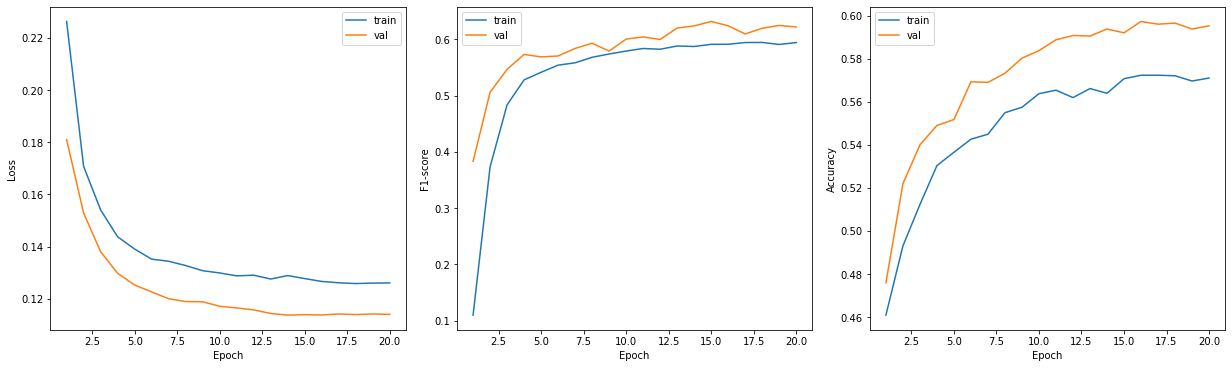

In [21]:
plotMetrics(losses, f1, acc)

Make a function to test the model on validation/test set.

In [15]:
def testNet(model, dataloader, dataset_size, threshold=0.5, return_predictions = False):
    running_corrects = 0
    running_f1_score = 0.0
    predictions = [] # outputs given a probability threshold
    
    # evaluation mode for validation
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = torch.sigmoid(model(inputs)) 
            preds = outputs > torch.tensor(threshold).to(device)
            
            # append the outputs of a batch
            if return_predictions == True:
                for i in range(preds.size(0)):
                    predictions.append(preds[i].to("cpu").numpy())
            
            running_corrects += accuracy_score(labels.data.cpu(), preds.data.cpu(), normalize=False)
            running_f1_score += f1_score(labels.data.cpu(), preds.data.cpu(), average="micro") * inputs.size(0)
            
    acc = running_corrects / dataset_size
    f1 = running_f1_score / dataset_size
    predictions = np.array(predictions)
    
    print(f"Acc: {acc:.4f} F1: {f1:.4f}")
    
    if return_predictions == True:
        return predictions
    else:
        return acc, f1

Define a function that gets the output from our network. We want the *output* (i.e. probabilities) from the validation data instead of the *predictions* (i.e. label 0 or 1) in order to tune the threshold for selecting the label for each class. This is because our data is imbalanced, and having a general threshold of 0.5 might not be optimal.

In [24]:
def getOutput(model, dataloader):
    outputs = []
    lbls = []
    # evaluation mode for validation
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # we need to add the sigmoid since now we don't have a loss function with integrated sigmoid
            output = torch.sigmoid(model(inputs).double()) 
            
            # append the outputs of a batch
            for i in range(output.size(0)):
                outputs.append(output[i].to("cpu").numpy())
                lbls.append(labels[i].to("cpu").numpy())
    return np.array(outputs), np.array(lbls)

In [88]:
model_ft = models.resnet34()
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 14)
model_ft.load_state_dict(torch.load("resnet34_model.pkl"))
model_ft = model_ft.to(device)
val_output, val_labels = getOutput(model_ft, dataloaders["val"])
print(val_output)
print(val_labels)

[[9.14731292e-06 4.97127231e-04 1.22884100e-03 ... 3.84097081e-03
  4.87350968e-04 4.02134128e-04]
 [5.88436279e-05 2.76425273e-04 8.42674493e-05 ... 4.07279275e-05
  2.31290239e-04 1.09799162e-04]
 [4.18811361e-05 3.13180546e-05 6.24964153e-05 ... 8.71289774e-05
  5.63335768e-05 4.83505128e-04]
 ...
 [1.08520494e-03 1.88130236e-04 3.64774308e-02 ... 2.37986048e-04
  1.72682830e-04 2.52411884e-04]
 [1.36701653e-05 1.79895527e-04 1.97703069e-03 ... 1.15591404e-04
  8.02730374e-05 2.40447469e-04]
 [1.29051043e-04 5.31300731e-05 1.99847431e-04 ... 1.38180543e-04
  2.24726968e-05 1.68212239e-03]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Now we choose the probability thresholds for each class by maximizing the F1-score. This can be done by defining a function that returns the *negative* F1-score and *minimizing* this function using some general optimization algorithm.

In [26]:
def thrToF1(threshold, labels, outputs):
    return -f1_score(labels, (outputs > threshold).astype("int"), average="micro")

In [106]:
from scipy.optimize import fmin
#best_thr = fmin(thrToF1, args=(val_labels, val_output), x0=[0.5 for i in range(14)])
best_thr = fmin(thrToF1, args=(val_labels, val_output), x0=0.5)
print(best_thr)

Optimization terminated successfully.
         Current function value: -0.790200
         Iterations: 12
         Function evaluations: 26
[0.37539062]


Then we can test the model with the newly found threshold(s) to see if the performance metrics improve.

In [107]:
testNet(model_ft, dataloaders["val"], dataset_sizes["val"], threshold=best_thr)


Acc: 0.7015 F1: 0.7874


(0.7015, 0.7873945482924489)

Below we define a sort of *minimum viable product* CNN for comparison.

In [9]:
import torch.nn.functional as F
pooling_size = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(512*8*8, 100)
        self.fc2 = nn.Linear(100, 100)
        #self.fc3 = nn.Sequential(nn.Linear(100, output_size), nn.Sigmoid())
        self.fc3 = nn.Linear(100, 14)


    def forward(self, x):
       
        #repeating layers of n*(conv + relu) + max_pool
        x = self.conv1(x)
        x = F.relu(x)        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, pooling_size)
        
        x = self.conv3(x)
        x = F.relu(x)        
        x = self.conv4(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, pooling_size)
        
        x = self.conv5(x)
        x = F.relu(x)        
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)

        x = F.max_pool2d(x, pooling_size)
        
        x = self.conv8(x)
        x = F.relu(x)        
        x = self.conv9(x)
        x = F.relu(x)
        x = self.conv10(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, pooling_size)
        
        x = self.conv11(x)
        x = F.relu(x)        
        x = self.conv12(x)
        x = F.relu(x)
        x = self.conv13(x)
        x = F.relu(x)
        
        #no pooling as  it would make dimensions very small (4x4)
        #x = F.max_pool2d(x, pooling_size)
        
        #print(x.size())
        
        # pass through linear layers and add drop out
        x = self.drop_out(x)
        x = x.view(x.size(0), 512*8*8)
        x = F.relu(self.fc1(x))
        x = self.drop_out(x)
        x = F.relu(self.fc2(x))
        output = self.fc3(x)

        return output

In [10]:
model = Net().to(device)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.001, max_lr=0.01)

In [11]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

11098110


In [14]:
model, losses, f1, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                                                      num_epochs=20)

Epoch 1/20
----------
train Loss: 0.2595 Acc: 0.4904 F1: 0.0002
val Loss: 0.2110 Acc: 0.4923 F1: 0.0000

Epoch 2/20
----------
train Loss: 0.2152 Acc: 0.4909 F1: 0.0001
val Loss: 0.2109 Acc: 0.4923 F1: 0.0000

Epoch 3/20
----------
train Loss: 0.2146 Acc: 0.4909 F1: 0.0000
val Loss: 0.2112 Acc: 0.4923 F1: 0.0000

Epoch 4/20
----------
train Loss: 0.2142 Acc: 0.4909 F1: 0.0000
val Loss: 0.2109 Acc: 0.4923 F1: 0.0000

Epoch 5/20
----------
train Loss: 0.2140 Acc: 0.4909 F1: 0.0000
val Loss: 0.2111 Acc: 0.4923 F1: 0.0000

Epoch 6/20
----------
train Loss: 0.2138 Acc: 0.4909 F1: 0.0000
val Loss: 0.2113 Acc: 0.4923 F1: 0.0000

Epoch 7/20
----------
train Loss: 0.2136 Acc: 0.4909 F1: 0.0000
val Loss: 0.2112 Acc: 0.4923 F1: 0.0000

Epoch 8/20
----------
train Loss: 0.2133 Acc: 0.4909 F1: 0.0000
val Loss: 0.2109 Acc: 0.4923 F1: 0.0000

Epoch 9/20
----------
train Loss: 0.2133 Acc: 0.4909 F1: 0.0000
val Loss: 0.2109 Acc: 0.4923 F1: 0.0000

Epoch 10/20
----------
train Loss: 0.2131 Acc: 0.4909 F

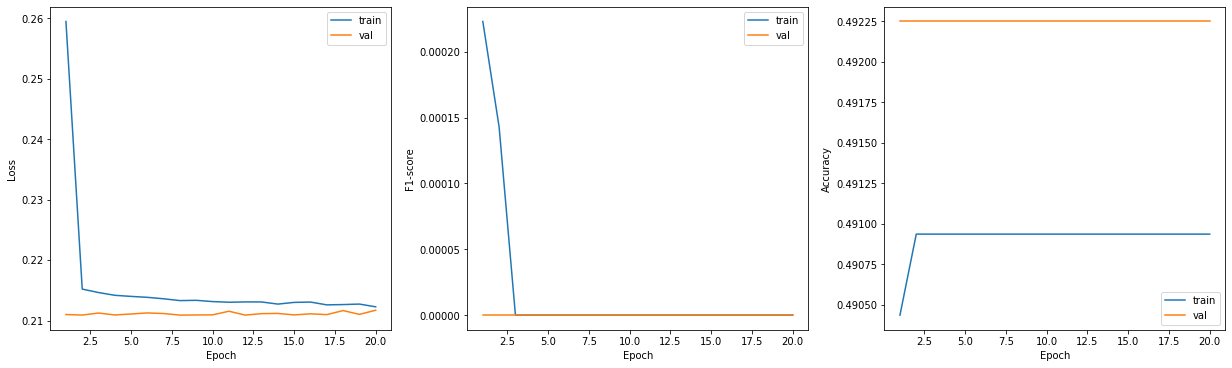

In [17]:
plotMetrics(losses, f1, acc)

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [28]:
torch.save(model_ft.state_dict(), 'resnet34_model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [38]:
# extract the test images
root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
test_path = 'test'

data_zip_name = 'image-test-corpus-I139ArJ.zip'

with zipfile.ZipFile(data_zip_name) as zip_f:
    zip_f.extractall(test_path)

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')

First we need to define a custom data set for the test data. We need to make sure that the order of predictions correspond to the order of images, and this time we return only an image, not the labels. NB! The code assumes that the test images are located in the current directory in `test/images`.

In [98]:
class TestDataSet(Dataset):
    def __init__(self, image_numbers, transformations):
        self.images = image_numbers
        self.image_count = len(self.images)
        self.transformations = transformations
        
    def __getitem__(self, index):        
        img = plt.imread(f"test/images/im{self.images[index]}.jpg")
        # the dimensions of input need to be the same for all input, so we change greyscale images (128x128)
        # to RGB (128x128x3)
        if len(img.shape) < 3: # check for greyscale images
            img = np.stack((img,)*3, axis=-1) # add 3 dimensions to the last axis
        
        img = self.transformations(img) # apply transformations to the image only

        return img

    def __len__(self):
        return self.image_count

In [99]:
X = sorted([int(filename[2:-4]) for filename in os.listdir("test/images/")]) # read the image numbers as int, sorted
# no data augmentation, only resizing and normalization
test_transforms=  transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_data = TestDataSet(X, test_transforms)
testloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)


Define a function to get the predictions from the model.

In [66]:
def getPredictions(model, dataloader, threshold):
    predictions = []
    # evaluation mode for testing
    model.eval()
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            # we need to add the sigmoid since now we don't have a loss function with integrated sigmoid
            outputs = torch.sigmoid(model(inputs).double()) 
            preds = outputs > torch.tensor(threshold).to(device)
            # append the predictions of a batch
            for i in range(outputs.size(0)):
                predictions.append(preds[i].to("cpu").numpy())

    return np.array(predictions).astype("int")

In [108]:
y = getPredictions(model_ft, testloader, best_thr)

In [109]:
np.savetxt('results.txt', y, fmt='%d')